In [83]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random as rn
import math
import seaborn as sns
from sklearn.svm import SVR

In [84]:
# dataset = pd.read_csv('forecast.csv')
dataset = pd.read_csv('forecast.csv')
year = dataset.iloc[:-1, 0].values
X = dataset.iloc[:-1, 1:-1].values
y = dataset.iloc[:-1, -1].values

In [85]:
y = y.reshape(len(y),1)

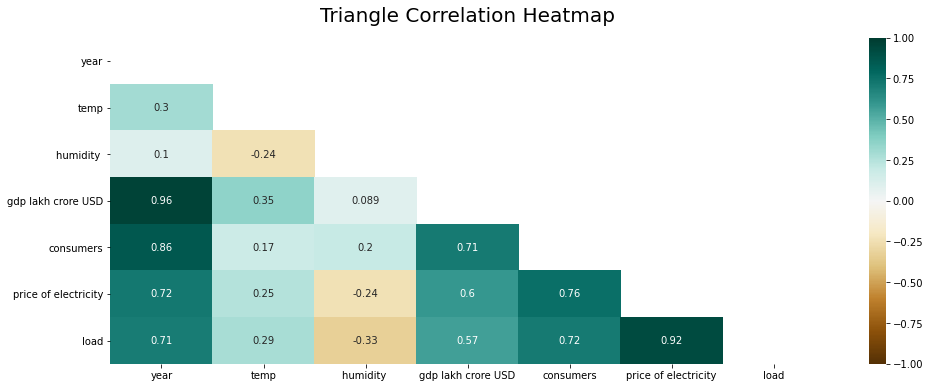

In [86]:
plt.figure(figsize=(16, 6))
mask = np.triu(np.ones_like(dataset.corr(), dtype=np.bool))
heatmap = sns.heatmap(dataset.corr(), mask=mask, vmin=-1, vmax=1, annot=True, 
                      cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':20}, 
                  pad=16);

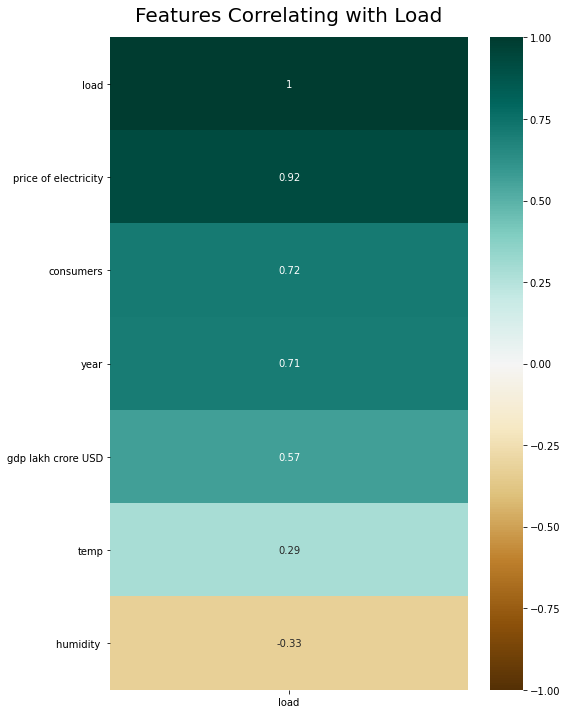

In [87]:
dataset.corr()[['load']].sort_values(by='load', ascending=False)
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(dataset.corr()[['load']].sort_values(by='load', 
                     ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Load', fontdict={'fontsize':20}, 
                  pad=16);

In [88]:
#  Preprocessing
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()
X = sc_X.fit_transform(X)
y = sc_y.fit_transform(y)
y = np.ravel(y)

In [89]:
# BSA parameters
pop_number = 100
dim = 2
pop_size = (pop_number, dim)
dim_rate=80
# bounds for penalty parameter,kernel parameter
low = (0.01, 0.01) 
high = (35000, 32) 
epoch = 50
globalminimum =np.zeros(epoch)

In [90]:
#  Population generation
def population_generation(low, high, pop_size):
  population = np.random.uniform(low, high, pop_size)
  return population

In [91]:
# Boundary control
def Boundary_control(offsprings):
  for i in range(pop_number):
    for j in range(dim):
      k = rn.random() < rn.random()
      if offsprings[i][j] < low[j]:
        if k:
          offsprings[i][j] = low[j]
        else:
          offsprings[i][j] = np.random.uniform(low[j], high[j])
      if offsprings[i][j] > high[j]:
        if k:
          offsprings[i][j] = high[j]
        else:
          offsprings[i][j] = np.random.uniform(low[j], high[j])
  return offsprings

In [92]:
#  SVR function
def SVR1(offspring):
  MAPE = np.zeros(pop_number)
  offsprings_svr = offspring
  for i in range(pop_number):
    
    regressor = SVR(kernel='linear', C = offsprings_svr[i][0], 
                epsilon = offsprings_svr[i][1])
    regressor.fit(X, y)
    # MAPE calculation
    y_true = np.array(sc_y.inverse_transform(y))
    y_pred = np.array( sc_y.inverse_transform(regressor.predict(X)))
    MAPE[i] = np.mean(np.divide(np.abs((y_true - y_pred)), y_true)) * 100
    MAPE = MAPE.reshape(len(MAPE),1)
  return MAPE
  
 

In [93]:
# Initilaization
pop = population_generation(low, high, pop_size)
fitness_pop= SVR1(pop)
historical_pop = population_generation(low, high, pop_size)

In [94]:
for epk in range(epoch):
  # Selection 1
  if rn.random() < rn.random():
    historical_pop = pop
  historical_pop = historical_pop[np.random.permutation(pop_number),:]
  F = 3*np.random.randn()
  map = np.zeros((pop_number,dim), dtype=int)
  if rn.random() < rn.random():
    for i in range(pop_number):
      u = np.random.permutation(dim)
      map[i][u[1:math.ceil(dim_rate*rn.random()*dim)]] = 1
  else:
    for i in range(pop_number):
      map[i][rn.randrange(1,dim+1)-1] = 1
  
  # Recombination (Mutation + Crossover) 
  offsprings = pop+(map*F)*(historical_pop-pop)

  # Call boundary control
  offspring = Boundary_control(offsprings)

  # Selection 2
  fitness_offsprings = SVR1(offsprings)
  indices = fitness_offsprings - fitness_pop
  indices = [i for i in range(pop_number) if indices[i][0]<0] 
  fitness_pop[indices]=fitness_offsprings[indices]
  pop[indices,:]=offsprings[indices,:]
  globalminimum[epk]=min(fitness_pop)
  globalminimizer=pop[indices,:] 

In [95]:
print(globalminimum)

[2.32491808 2.32464381 2.32464381 2.32464381 2.32464381 2.32460683
 2.32460683 2.32460683 2.32460683 2.3245433  2.3245433  2.3245433
 2.3245433  2.3245433  2.3245433  2.3245433  2.3245433  2.3245433
 2.32454083 2.32454083 2.32454083 2.32454083 2.32454083 2.32454083
 2.32454083 2.32454083 2.32454083 2.32454083 2.32454083 2.32454083
 2.32454083 2.32454083 2.32454083 2.32454083 2.32454083 2.3242265
 2.3242265  2.3242265  2.3242265  2.3242265  2.3242265  2.3242265
 2.3242265  2.3242265  2.3242265  2.3242265  2.3242265  2.3242265
 2.3242265  2.3242265 ]


In [96]:
print(globalminimizer)

[[1.08785823e+04 1.00000000e-02]
 [3.50000000e+04 1.00000000e-02]
 [2.12097308e+04 1.00000000e-02]]


In [97]:
#  forecasted load
regressor = SVR(kernel='linear', C = globalminimizer[-1][0], 
                epsilon = globalminimizer[-1][1])
regressor.fit(X, y)
sc_y.inverse_transform(regressor.predict(sc_X.transform([dataset.iloc[-1, 1:-1]])))


array([731.10198897])

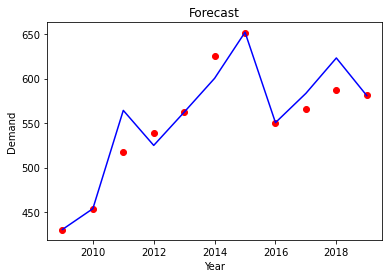

In [98]:
# curve between real and predicted demand
# real demand
plt.scatter(year, sc_y.inverse_transform(y), color = 'red')
# predicted demand with model 
plt.plot(year, sc_y.inverse_transform(regressor.predict(X)), color = 'blue')
plt.title('Forecast')
plt.xlabel('Year')
plt.ylabel('Demand')
plt.show()

In [99]:
# R2 score
from sklearn.metrics import r2_score
r2_score(sc_y.inverse_transform(y),sc_y.inverse_transform(regressor.predict(X)))

0.8942139136504376

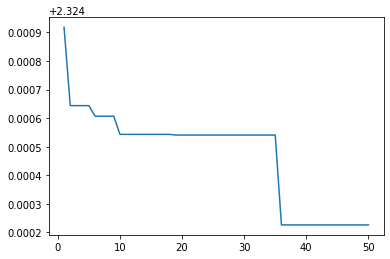

In [100]:
# print(np.array(globalminimum))
# print(np.arange(start=1, stop=epoch+1, step=1))
plt.plot(np.arange(start=1, stop=epoch+1, step=1), np.array(globalminimum))
plt.plot(np.arange(start=1, stop=epoch+1, step=1)